# Deep Q Network

## 相关概念

一个回合中智能体从起始到结束的所有奖励记作$R_1, \cdots, R_t, \cdots, R_n$。

#### 折扣回报：

$$U_t = R_t + \gamma R_{t + 1} + \gamma^2 R_{t + 2} + \cdots + \gamma^{n - t}R_n$$

其中$\gamma \in [0, 1]$为折扣率。

#### 动作价值函数：

$$Q_{\pi}(s_t, a_t) = E\left[ U_t | S_t = s_t, A_t = a_t \right]$$

上式中的期望消除了$t$时刻后的所有状态$S_{t + 1}, \cdots$和所有动作$A_{t + 1}, \cdots$。

#### 最优动作价值函数：

$$Q_{*}(s_t, a_t) = \max_{\pi} Q_{\pi}(s_t, a_t), \quad \forall s_t \in S_t, a_t \in A_t$$

未来无论采取什么策略$\pi$，回报$U_t$的期望不会超过$Q_{*}$。

#### DQN (deep Q network)：

利用神经网络$Q(s, a; w)$模拟$Q_{*}$。

#### TD (temporal difference)：

$$Q(s_t, a_t; w) \approx r_t + \gamma \max_{a \in A} Q(s_{t + 1}, a; w)$$

上式左侧为预测$\hat{q}_t$，右侧为TD目标$\hat{y}_t$。

#### 损失函数及梯度：

$$L(w) = \frac{1}{2}\left[ Q(s_t, a_t; w) - \hat{y}_t \right]^2$$

$$\Delta_w L(w) = (\hat{q}_t - \hat{y}_t) \cdot \Delta_w Q(s_t, a_t; w)$$

#### $\epsilon$-greedy策略：

$$
a_t = 
\begin{cases} 
\text{argmax}_a \; Q(s_t, a; w) & \text{with probability } (1 - \epsilon) \\ 
\text{uniformly extract from } A & \text{with probability } \epsilon 
\end{cases}
$$

#### warm up：

(1) 由于Q网络尚未训练，warm up阶段智能体随机探索，可减少初期的偏差。

(2) 更广泛地探索状态-动作空间，提高探索性。

(3) 收集初始经验放入经验缓存，减少由于数据不足导致的过拟合。

#### 经验缓存 (experience replay buffer)：

存储多个四元组$(s_t, a_t, r_t, s_{t + 1})$。

## 训练方法

设DQN的当前参数分别为$w_{now}$。

(1) DQN前向传播，得到：$\hat{q}_j = Q(s_j, a_j; w_{now})$和$\hat{q}_{j + 1} = \max_{a \in A} Q(s_{j + 1}, a; w_{now})$。

(2) 计算TD目标和TD误差：$\hat{y}_j = r_j + \gamma \hat{q}_{j + 1}$和$\delta_j = \hat{q}_j - \hat{y}_j$。

(3) 反向传播计算梯度：$g_t = \Delta_{w} Q(s_j, a_j; w_{now})$。

(4) 更新参数：$w_{new} = w_{now} - \alpha \cdot \delta_j \cdot g_j$。

# Double Q Network

## 相关概念

#### 高估：

(1) 用DQN做出的预测去更新DQN自身，会导致高估的累积。

(2) 假设DQN的输出是$Q_{*}$加上均值为零的噪声$\epsilon$，即$Q(s, a; w) = Q_{*}(s, a) + \epsilon$，则$E_{\epsilon}[\max_{a \in A} Q(s, a; w)] \geq \max_{a \in A} Q_{*}(s, a)$。

(3) 非均匀的高估，会导致决策不可靠。

## 训练方法

设DQN和目标网络的当前参数分别为$w_{now}$和$w_{now}^-$。

(1) DQN前向传播，得到：$\hat{q}_j = Q(s_j, a_j; w_{now})$。

(2) 目标网络前向传播，得到：$\hat{q}_{j + 1}^- = \max_{a \in A}Q(s_{j + 1}, a; w_{now}^-)$.

(3) 计算TD目标和TD误差：$\hat{y}_j^- = r_j + \gamma \cdot \hat{q}_{j + 1}^-$和$\delta_j = \hat{q}_j - \hat{y}_j^-$.

(4) 反向传播计算梯度：$g_t = \Delta_{w} Q(s_j, a_j; w_{now})$。

(5) 更新参数：$w_{new} = w_{now} - \alpha \cdot \delta_j \cdot g_j$。

(6) 使用加权平均更新目标网络参数：$w_{now}^- = \tau \cdot w_{new} + (1 - \tau) \cdot w_{now}^-$。

# 代码

In [1]:
# 导入库
import os
import gym
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
# 定义Q-Network
class QNet(nn.Module):
    def __init__(self, state_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_actions)
    
    def forward(self, state):
        state = state.float()
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# 定义经验缓存
class ReplayBuffer:
    def __init__(self, max_size, device):
        self.max_size = max_size
        self.device = device
        self.size = 0
        self.state = []
        self.action = []
        self.reward = []
        self.done = []
        self.next_state = []
        
    def push(self, state, action, reward, done, next_state):
        if self.size < self.max_size:
            self.state.append(state)
            self.action.append(action)
            self.reward.append(reward)
            self.done.append(done)
            self.next_state.append(next_state)
        else:
            position = self.size % self.max_size
            self.state[position] = state
            self.action[position] = action
            self.reward[position] = reward
            self.done[position] = done
            self.next_state[position] = next_state
        self.size += 1
        
    def sample(self, n):
        total_number = min(self.size, self.max_size)
        indices = np.random.randint(total_number, size=n)
        state = torch.tensor(np.array([self.state[i] for i in indices], dtype=np.float32), device=self.device)
        action = torch.tensor([self.action[i] for i in indices], device=self.device, dtype=torch.long)
        reward = torch.tensor([self.reward[i] for i in indices], device=self.device, dtype=torch.float32)
        done = torch.tensor([self.done[i] for i in indices], device=self.device, dtype=torch.float32)
        next_state = torch.tensor(np.array([self.next_state[i] for i in indices], dtype=np.float32), device=self.device)
        return state, action, reward, done, next_state

In [4]:
# 定义DQN类
class DQN:
    def __init__(self, state_size, num_actions, discount, device):
        self.discount = discount
        self.Q = QNet(state_size, num_actions).to(device)
        self.target_Q = QNet(state_size, num_actions).to(device)
        self.target_Q.load_state_dict(self.Q.state_dict())
        
    def get_action(self, state):
        qvals = self.Q(state)
        return qvals.argmax().item()
    
    def compute_loss(self, s_batch, a_batch, r_batch, d_batch, next_s_batch):
        # s_batch, next_s_batch: (batch_size, state_size)
        # a_batch, r_batch, d_batch: (batch_size)
        # self.target_Q(s_batch): (batch_size, num_actions)
        # qvals: (batch_size)
        qvals = self.Q(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze()
        # next_qvals由target network计算得到，使用detach()避免求导
        next_qvals, _ = self.target_Q(next_s_batch).detach().max(dim=1)
        loss = F.mse_loss(r_batch + self.discount * next_qvals * (1 - d_batch), qvals)
        return loss
    
    def soft_update(self, tau=0.01):
        for target_param, param in zip(self.target_Q.parameters(), self.Q.parameters()):
            target_param.data.copy_(target_param.data * (1 - tau) + param.data * tau)

In [5]:
# 定义训练函数
def train(args, env, agent):
    replay_buffer = ReplayBuffer(10000, args.device)
    optimizer = torch.optim.Adam(agent.Q.parameters(), lr=args.lr)
    
    epsilon = 1
    epsilon_max = 1
    epsilon_min = 0.1
    episode_reward = 0
    episode_length = 0
    max_episode_reward = -float('inf')
    log = defaultdict(list)
    log['loss'].append(0)
    
    agent.Q.train()
    state, _ = env.reset()
    for i in range(args.max_steps):
        # \epsilon-greedy strategy
        if np.random.rand() < epsilon or i < args.warmup_steps:
            action = env.action_space.sample()
        else:
            action = agent.get_action(torch.from_numpy(state).to(args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1

        replay_buffer.push(state, action, reward, done, next_state)
        state = next_state
        
        if done:
            log['episode_reward'].append(episode_reward)
            log['episode_length'].append(episode_length)
            loss = log['loss'][-1]
            print(f'i = {i}, reward = {episode_reward:.0f}, length = {episode_length}, max reward = {max_episode_reward}, loss = {loss:.1e}, epsilon = {epsilon:.3f}')
            
            if episode_reward > max_episode_reward:
                max_episode_reward = episode_reward
                save_path = os.path.join(args.output_dir, 'model.bin')
                torch.save(agent.Q.state_dict(), save_path)
            
            episode_reward = 0
            episode_length = 0
            epsilon = max(epsilon - (epsilon_max - epsilon_min) * args.epsilon_decay, epsilon_min)
            state, _ = env.reset()
            
        if i > args.warmup_steps:
            bs, ba, br, bd, bns = replay_buffer.sample(n=args.batch_size)
            loss = agent.compute_loss(bs, ba, br, bd, bns)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            log['loss'].append(loss.item())
            agent.soft_update()
    
    plt.plot(np.arange(len(log['episode_reward'])), log['episode_reward'])
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Reward Curve')
    plt.show()
    plt.close()
    
    window_size = 10  # 可以根据需要调整窗口大小
    smoothed_rewards = np.convolve(log['episode_reward'], np.ones(window_size) / window_size, mode='valid')
    
    plt.plot(np.arange(len(smoothed_rewards)), smoothed_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Reward Curve (Smoothed)')
    plt.show()
    plt.close()

In [6]:
# 定义测试函数
def eval(args, env):
    agent = DQN(args.state_size, args.num_actions, args.discount, args.device)
    model_path = os.path.join(args.output_dir, 'model.bin')
    agent.Q.load_state_dict(torch.load(model_path))
    agent.Q.to(args.device)
    
    episode_reward = 0
    episode_length = 0
    state, _ = env.reset()
    for _ in range(5000):
        action = agent.get_action(torch.from_numpy(state).to(args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            state, _ = env.reset()
            print(f'episode reward = {episode_reward}, episode length = {episode_length}')
            episode_reward = 0
            episode_length = 0

i = 28, reward = 29, length = 29, max reward = -inf, loss = 0.0e+00, epsilon = 1.000
i = 45, reward = 17, length = 17, max reward = 29.0, loss = 0.0e+00, epsilon = 0.999
i = 114, reward = 69, length = 69, max reward = 29.0, loss = 0.0e+00, epsilon = 0.998
i = 129, reward = 15, length = 15, max reward = 69.0, loss = 0.0e+00, epsilon = 0.997
i = 168, reward = 39, length = 39, max reward = 69.0, loss = 0.0e+00, epsilon = 0.996
i = 193, reward = 25, length = 25, max reward = 69.0, loss = 0.0e+00, epsilon = 0.995
i = 207, reward = 14, length = 14, max reward = 69.0, loss = 0.0e+00, epsilon = 0.995
i = 230, reward = 23, length = 23, max reward = 69.0, loss = 0.0e+00, epsilon = 0.994
i = 258, reward = 28, length = 28, max reward = 69.0, loss = 0.0e+00, epsilon = 0.993
i = 300, reward = 42, length = 42, max reward = 69.0, loss = 0.0e+00, epsilon = 0.992
i = 325, reward = 25, length = 25, max reward = 69.0, loss = 0.0e+00, epsilon = 0.991
i = 353, reward = 28, length = 28, max reward = 69.0, lo

i = 10020, reward = 36, length = 36, max reward = 73.0, loss = 5.8e-01, epsilon = 0.586
i = 10034, reward = 14, length = 14, max reward = 73.0, loss = 2.7e-01, epsilon = 0.585
i = 10048, reward = 14, length = 14, max reward = 73.0, loss = 7.0e-02, epsilon = 0.584
i = 10059, reward = 11, length = 11, max reward = 73.0, loss = 2.4e-02, epsilon = 0.583
i = 10070, reward = 11, length = 11, max reward = 73.0, loss = 2.6e-02, epsilon = 0.582
i = 10081, reward = 11, length = 11, max reward = 73.0, loss = 2.5e-02, epsilon = 0.581
i = 10094, reward = 13, length = 13, max reward = 73.0, loss = 2.7e-02, epsilon = 0.581
i = 10106, reward = 12, length = 12, max reward = 73.0, loss = 3.7e-02, epsilon = 0.580
i = 10121, reward = 15, length = 15, max reward = 73.0, loss = 2.4e-02, epsilon = 0.579
i = 10132, reward = 11, length = 11, max reward = 73.0, loss = 2.6e-02, epsilon = 0.578
i = 10145, reward = 13, length = 13, max reward = 73.0, loss = 5.8e-02, epsilon = 0.577
i = 10164, reward = 19, length =

i = 16597, reward = 177, length = 177, max reward = 208.0, loss = 2.0e+00, epsilon = 0.502
i = 16691, reward = 94, length = 94, max reward = 208.0, loss = 1.8e+00, epsilon = 0.501
i = 16719, reward = 28, length = 28, max reward = 208.0, loss = 4.7e+01, epsilon = 0.500
i = 16746, reward = 27, length = 27, max reward = 208.0, loss = 2.1e+00, epsilon = 0.500
i = 16771, reward = 25, length = 25, max reward = 208.0, loss = 1.6e+01, epsilon = 0.499
i = 16922, reward = 151, length = 151, max reward = 208.0, loss = 1.4e+01, epsilon = 0.498
i = 16970, reward = 48, length = 48, max reward = 208.0, loss = 1.8e+00, epsilon = 0.497
i = 17058, reward = 88, length = 88, max reward = 208.0, loss = 2.3e+00, epsilon = 0.496
i = 17179, reward = 121, length = 121, max reward = 208.0, loss = 3.3e+00, epsilon = 0.495
i = 17320, reward = 141, length = 141, max reward = 208.0, loss = 1.5e+00, epsilon = 0.494
i = 17459, reward = 139, length = 139, max reward = 208.0, loss = 2.2e+00, epsilon = 0.493
i = 17666, 

i = 26920, reward = 222, length = 222, max reward = 330.0, loss = 1.1e+00, epsilon = 0.419
i = 27125, reward = 205, length = 205, max reward = 330.0, loss = 7.0e-01, epsilon = 0.419
i = 27138, reward = 13, length = 13, max reward = 330.0, loss = 2.4e+00, epsilon = 0.418
i = 27190, reward = 52, length = 52, max reward = 330.0, loss = 1.8e+00, epsilon = 0.417
i = 27349, reward = 159, length = 159, max reward = 330.0, loss = 4.6e+01, epsilon = 0.416
i = 27591, reward = 242, length = 242, max reward = 330.0, loss = 5.7e+00, epsilon = 0.415
i = 27756, reward = 165, length = 165, max reward = 330.0, loss = 3.6e+00, epsilon = 0.414
i = 27952, reward = 196, length = 196, max reward = 330.0, loss = 4.9e+01, epsilon = 0.413
i = 28089, reward = 137, length = 137, max reward = 330.0, loss = 2.0e+00, epsilon = 0.412
i = 28102, reward = 13, length = 13, max reward = 330.0, loss = 3.0e+00, epsilon = 0.411
i = 28292, reward = 190, length = 190, max reward = 330.0, loss = 7.2e+00, epsilon = 0.410
i = 2

i = 37127, reward = 148, length = 148, max reward = 330.0, loss = 8.3e-01, epsilon = 0.338
i = 37253, reward = 126, length = 126, max reward = 330.0, loss = 1.2e+00, epsilon = 0.337
i = 37400, reward = 147, length = 147, max reward = 330.0, loss = 4.4e-01, epsilon = 0.336
i = 37582, reward = 182, length = 182, max reward = 330.0, loss = 5.8e-01, epsilon = 0.335
i = 37753, reward = 171, length = 171, max reward = 330.0, loss = 7.7e-01, epsilon = 0.334
i = 37902, reward = 149, length = 149, max reward = 330.0, loss = 8.4e-01, epsilon = 0.333
i = 38046, reward = 144, length = 144, max reward = 330.0, loss = 3.0e-01, epsilon = 0.332
i = 38211, reward = 165, length = 165, max reward = 330.0, loss = 8.9e-01, epsilon = 0.331
i = 38242, reward = 31, length = 31, max reward = 330.0, loss = 4.4e-01, epsilon = 0.330
i = 38371, reward = 129, length = 129, max reward = 330.0, loss = 5.1e-01, epsilon = 0.329
i = 38511, reward = 140, length = 140, max reward = 330.0, loss = 3.7e-01, epsilon = 0.329
i

i = 47374, reward = 178, length = 178, max reward = 330.0, loss = 3.4e+00, epsilon = 0.256
i = 47525, reward = 151, length = 151, max reward = 330.0, loss = 2.0e-01, epsilon = 0.255
i = 47654, reward = 129, length = 129, max reward = 330.0, loss = 1.4e+00, epsilon = 0.254
i = 47833, reward = 179, length = 179, max reward = 330.0, loss = 2.1e-01, epsilon = 0.253
i = 48028, reward = 195, length = 195, max reward = 330.0, loss = 1.8e-01, epsilon = 0.252
i = 48103, reward = 75, length = 75, max reward = 330.0, loss = 1.1e+00, epsilon = 0.251
i = 48235, reward = 132, length = 132, max reward = 330.0, loss = 3.5e-01, epsilon = 0.250
i = 48406, reward = 171, length = 171, max reward = 330.0, loss = 3.0e-01, epsilon = 0.249
i = 48621, reward = 215, length = 215, max reward = 330.0, loss = 1.6e-01, epsilon = 0.248
i = 48771, reward = 150, length = 150, max reward = 330.0, loss = 5.1e-01, epsilon = 0.248
i = 48945, reward = 174, length = 174, max reward = 330.0, loss = 8.8e-01, epsilon = 0.247
i

i = 66604, reward = 193, length = 193, max reward = 500.0, loss = 2.9e-01, epsilon = 0.174
i = 67072, reward = 468, length = 468, max reward = 500.0, loss = 4.2e-01, epsilon = 0.173
i = 67328, reward = 256, length = 256, max reward = 500.0, loss = 3.1e-01, epsilon = 0.172
i = 67536, reward = 208, length = 208, max reward = 500.0, loss = 2.5e-01, epsilon = 0.171
i = 67593, reward = 57, length = 57, max reward = 500.0, loss = 2.7e-01, epsilon = 0.170
i = 67891, reward = 298, length = 298, max reward = 500.0, loss = 1.5e-01, epsilon = 0.169
i = 68134, reward = 243, length = 243, max reward = 500.0, loss = 1.7e+00, epsilon = 0.168
i = 68183, reward = 49, length = 49, max reward = 500.0, loss = 1.4e+00, epsilon = 0.167
i = 68243, reward = 60, length = 60, max reward = 500.0, loss = 2.4e-01, epsilon = 0.167
i = 68323, reward = 80, length = 80, max reward = 500.0, loss = 2.4e-01, epsilon = 0.166
i = 68621, reward = 298, length = 298, max reward = 500.0, loss = 1.6e-01, epsilon = 0.165
i = 688

i = 84395, reward = 277, length = 277, max reward = 500.0, loss = 1.2e-01, epsilon = 0.100
i = 84895, reward = 500, length = 500, max reward = 500.0, loss = 4.4e-01, epsilon = 0.100
i = 85245, reward = 350, length = 350, max reward = 500.0, loss = 1.3e-01, epsilon = 0.100
i = 85414, reward = 169, length = 169, max reward = 500.0, loss = 8.6e-02, epsilon = 0.100
i = 85648, reward = 234, length = 234, max reward = 500.0, loss = 4.4e-01, epsilon = 0.100
i = 86148, reward = 500, length = 500, max reward = 500.0, loss = 5.4e-01, epsilon = 0.100
i = 86412, reward = 264, length = 264, max reward = 500.0, loss = 2.9e-01, epsilon = 0.100
i = 86477, reward = 65, length = 65, max reward = 500.0, loss = 9.6e-01, epsilon = 0.100
i = 86547, reward = 70, length = 70, max reward = 500.0, loss = 1.5e-01, epsilon = 0.100
i = 86655, reward = 108, length = 108, max reward = 500.0, loss = 2.7e-01, epsilon = 0.100
i = 86715, reward = 60, length = 60, max reward = 500.0, loss = 1.3e-01, epsilon = 0.100
i = 8

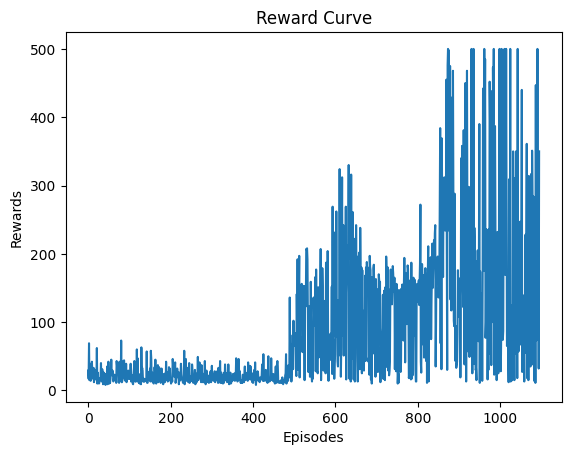

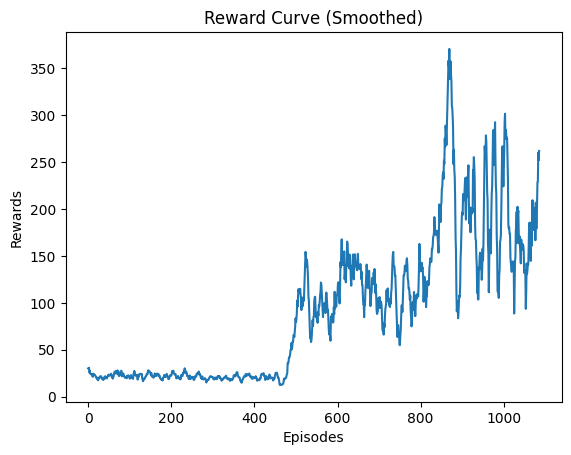

episode reward = 321.0, episode length = 321
episode reward = 329.0, episode length = 329
episode reward = 331.0, episode length = 331
episode reward = 325.0, episode length = 325
episode reward = 306.0, episode length = 306
episode reward = 329.0, episode length = 329
episode reward = 319.0, episode length = 319
episode reward = 333.0, episode length = 333
episode reward = 323.0, episode length = 323
episode reward = 319.0, episode length = 319
episode reward = 332.0, episode length = 332
episode reward = 326.0, episode length = 326
episode reward = 325.0, episode length = 325
episode reward = 315.0, episode length = 315
episode reward = 328.0, episode length = 328


In [7]:
# 运行
args = argparse.ArgumentParser()
args.env = 'CartPole-v1'
args.state_size = 4
args.num_actions = 2
args.discount = 0.98
args.max_steps = 100000
args.lr = 1e-3
args.batch_size = 32
args.warmup_steps = 1e4
args.output_dir = 'output'
args.epsilon_decay = 1 / 1000
if torch.backends.mps.is_available():
    args.device = torch.device('mps')
elif torch.cuda.is_available():
    args.device = torch.device('cuda')
else:
    args.device = torch.device('cpu')


if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
    
env = gym.make(args.env)
env.reset(seed=42)
env.action_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
agent = DQN(args.state_size, args.num_actions, args.discount, args.device)
train(args, env, agent)
eval(args, env)